# Visualizations

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import itertools
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.patches as mpatches
import mapclassify
sns.set()

In [2]:
zips = ('78701', '78702', '78703', '78704', '78705', '78717', '78719','78721',
        '78722', '78723', '78724', '78725', '78726', '78727', '78728', '78729',
        '78730', '78731', '78732', '78733', '78734', '78735', '78736', '78737',
        '78739', '78741', '78742', '78744', '78745', '78746', '78747', '78748',
        '78749', '78750', '78751', '78752', '78753', '78754', '78756', '78757',
        '78758', '78759', '78617', '78653', '78660')

In [3]:
df = pd.read_csv("clean_data/full_clean_data.csv").iloc[:,1:]
geo_zip_full = gpd.read_file("census_templates/ADP_zip_codes.geojson")

In [4]:
geo_zip = geo_zip_full[geo_zip_full['zipcode'].astype(str).isin(zips)]
geo_zip = geo_zip.loc[:,('zipcode', 'geometry')]

df['zipcode'] = df['zipcode'].astype(str)
df_geo = gpd.GeoDataFrame(pd.merge(df, geo_zip, on = ('zipcode'), how = 'outer'))

## City Stats

In [5]:
df_geo.groupby('year').sum()['Dem: Pop']

year
2011    1018880
2012    1047947
2013    1074019
2014    1105821
2015    1135360
2016    1161832
2017    1187784
2018    1212705
Name: Dem: Pop, dtype: int64

In [6]:
df_geo.groupby('year').mean()['Inc: PC Income']

year
2011    34758.200000
2012    35073.133333
2013    35865.577778
2014    36934.444444
2015    38192.355556
2016    39761.800000
2017    42228.533333
2018    44218.488889
Name: Inc: PC Income, dtype: float64

In [7]:
df_geo.groupby('year').mean()['Hsg: Median House Costs'] # or 1Y: Hsg: Median Gross Rent

year
2011    1268.111111
2012    1283.200000
2013    1299.866667
2014    1309.177778
2015    1327.266667
2016    1368.444444
2017    1420.844444
2018    1482.622222
Name: Hsg: Median House Costs, dtype: float64

## Lineplots

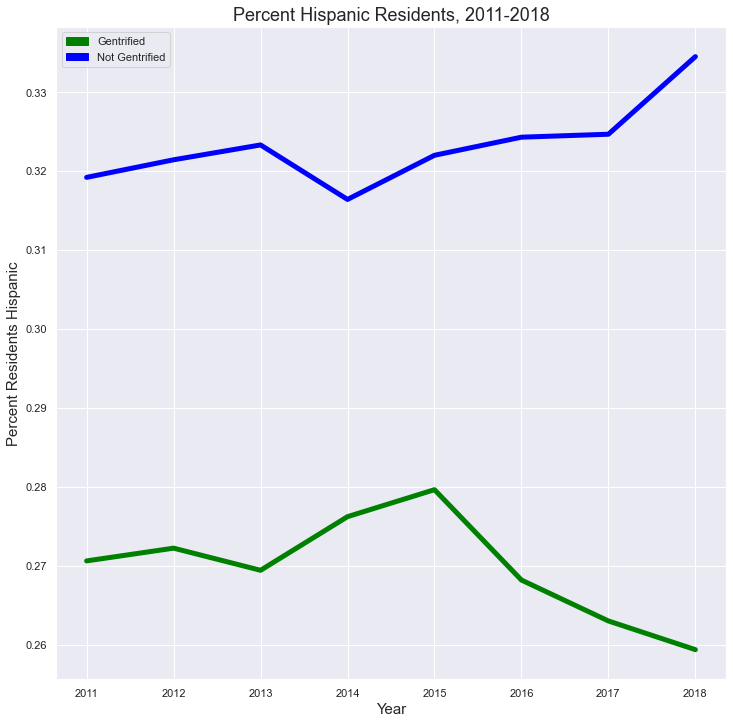

In [8]:
df.groupby("zipcode").sum()['Gentrified 1Y Median'].sort_values(ascending = False)

# hand selected zips with >= 3 years of 1y gentrif from ^
gent1_zips = ['78704', '78721', '78734', '78756', '78723', '78751', '78748', '78737']

gent1 = df[df['zipcode'].isin(gent1_zips)]
rest1 = df[~df['zipcode'].isin(gent1_zips)]

# Lineplots about gentrified vs non gentrified zips
# change out var for 'Hsg: Median House Costs', 'Y: % built pre-1970', 'Inc: Income >100K',
#                    'Div: % NH White', 'Div: % Latino', 'Div: % Black'
plt.figure(figsize=(12, 12))

sns.lineplot(x = gent1['year'],
            y = gent1['Div: % Hispanic'],
            color = "green",
            linewidth = 5, 
             ci = None)

sns.lineplot(x = rest1['year'],
            y = rest1['Div: % Hispanic'],
            color = "blue",
            linewidth = 5,
             ci = None)

#plt.ylim(.5, .85)
plt.xlabel('Year', fontsize = 15)
plt.ylabel("Percent Residents Hispanic", fontsize = 15)
plt.title('Percent Hispanic Residents, 2011-2018', fontsize = 18)

zip_patch = mpatches.Patch(color='green', label='Gentrified')
austin_patch = mpatches.Patch(color='blue', label='Not Gentrified')

plt.legend(handles=[zip_patch, austin_patch])

None

## Changes in median income by ZIP code between 2014 and 2019

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 91 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   year                                         360 non-null    int64  
 1   1 year                                       360 non-null    int64  
 2   5 years                                      360 non-null    int64  
 3   zipcode                                      360 non-null    object 
 4   Dem: Median Age                              360 non-null    float64
 5   Dem: % <18                                   360 non-null    float64
 6   Dem: Pop                                     360 non-null    int64  
 7   Div: % NH White                              360 non-null    float64
 8   Div: % NH Black                              360 non-null    float64
 9   Div: % Hispanic                              360 non-null    float64
 10  Di

In [10]:
zip_graph = df[["year","zipcode",'5Y CHG: Inc: Median Income Past 12m']][df["year"]==2014]
zip_graph = zip_graph.reset_index()
zip_graph = zip_graph.sort_values("5Y CHG: Inc: Median Income Past 12m")
avg_change = df[["year","zipcode","5Y CHG: Inc: Median Income Past 12m"]][df["year"]==2014].iloc[:,2].mean()

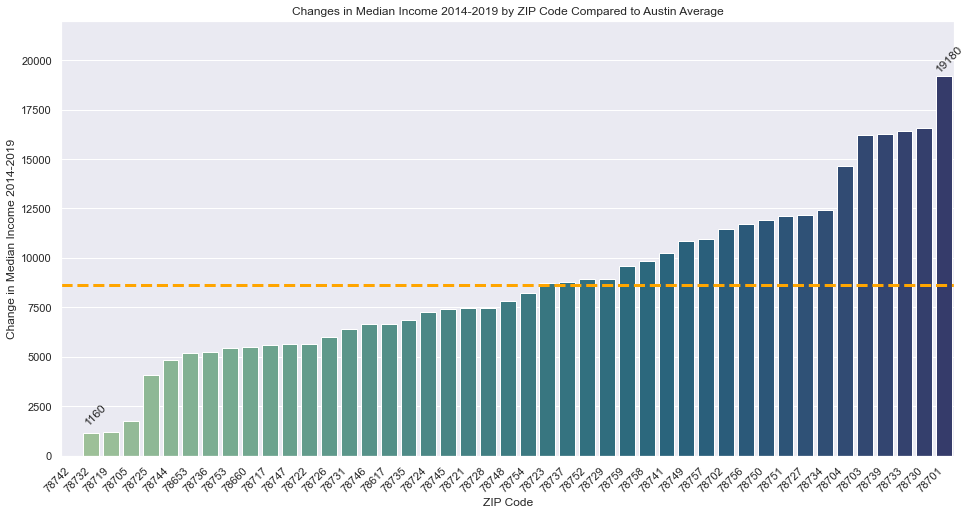

In [11]:
plt.figure(figsize=(16,8))
p = sns.barplot(data=zip_graph, 
                x="zipcode", 
                y="5Y CHG: Inc: Median Income Past 12m",
                palette="crest")


for i, bar in enumerate(p.patches):
    if (i == 1 or i == len(p.patches)-1):
      p.annotate(format(bar.get_height(), '.0f'), 
                   (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                   ha = 'center', va = 'center', rotation=45,
                   xytext = (5, 18), 
                   textcoords = 'offset points')
    
p = plt.xticks(rotation=45, horizontalalignment='right')
p = plt.ylim(0, 22000)
p = plt.xlabel("ZIP Code")
p = plt.ylabel("Change in Median Income 2014-2019")
p = plt.title("Changes in Median Income 2014-2019 by ZIP Code Compared to Austin Average")

plt.axhline(avg_change, color="orange", linewidth = 3, linestyle = "--")

plt.show(p)

## City Maps

<AxesSubplot:title={'center':'Population Density by Zip Code, 2018'}>

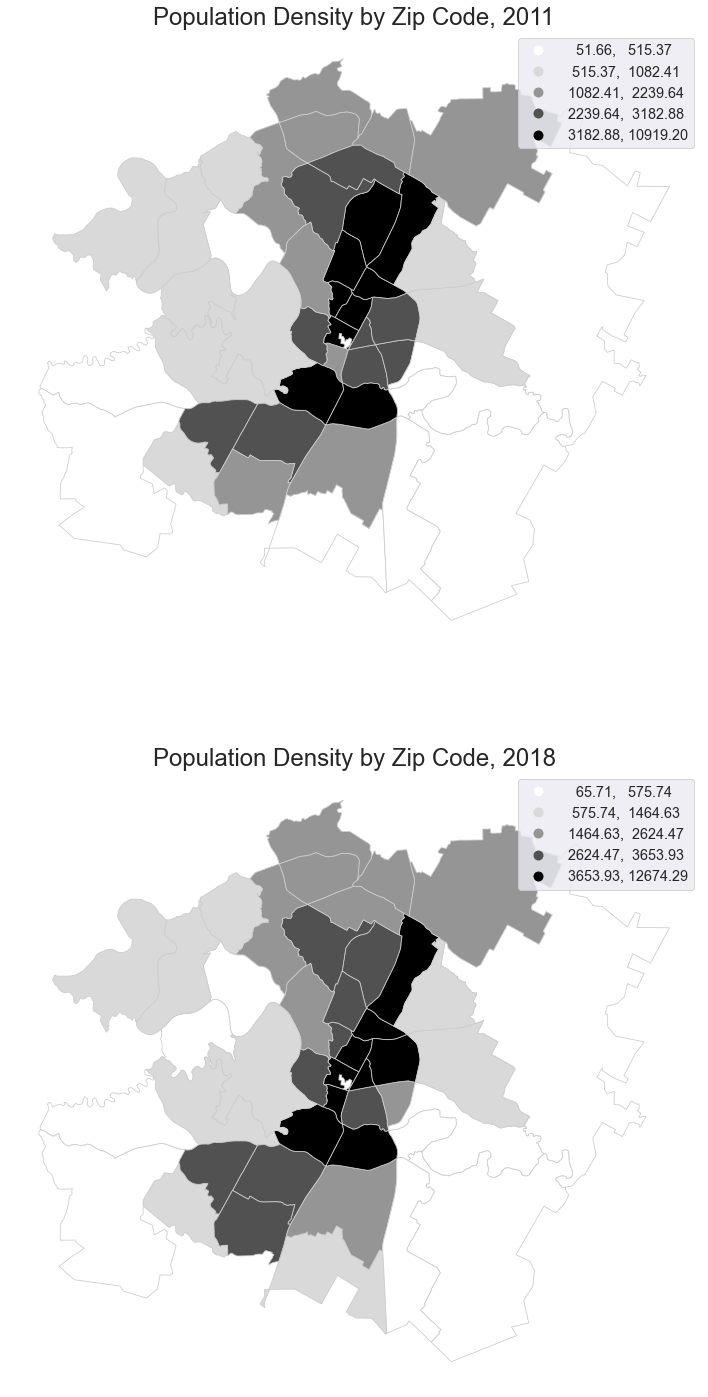

In [12]:
fig, (ax, ax2) = plt.subplots(2, figsize=(25,25))
ax.axis("off")
ax2.axis("off")

ax.set_title("Population Density by Zip Code, 2011", fontsize = 24)

df_geo[df_geo['year'] == 2011].plot(column = 'Dem: Pop Density', 
                  linewidth=0.8, ax=ax, edgecolor="0.8", 
                  scheme = 'quantiles',legend=True,legend_kwds=dict(loc='upper right',fontsize='large',
                  frameon=True),
                  cmap='Greys')
ax2.set_title("Population Density by Zip Code, 2018", fontsize = 24)

df_geo[df_geo['year'] == 2018].plot(column = 'Dem: Pop Density', 
                  linewidth=0.8, ax=ax2, edgecolor="0.8", 
                  scheme = 'quantiles',legend=True,legend_kwds=dict(loc='upper right',fontsize='large',
                  frameon=True),
                  cmap='Greys')

# ax.legend(fontsize=18)
# ax2.legend(fontsize=18)

In [13]:
df.columns

Index(['year', '1 year', '5 years', 'zipcode', 'Dem: Median Age', 'Dem: % <18',
       'Dem: Pop', 'Div: % NH White', 'Div: % NH Black', 'Div: % Hispanic',
       'Div: % NH Asian', 'Div: Max % One Race', 'Div: % Born in US',
       'Ed: % Less than HS', 'Ed: % w/ Grad', 'Comp: % Married',
       'Comp: % Fam HHs', 'Hsg: % Paying >20% Income on Housing',
       'Hsg: % Paying >30% Income on Housing',
       'Hsg: % Paying >40% Income on Housing', 'Hsg: Median House Costs',
       'Inc: Income >40K', 'Inc: Income >60K', 'Inc: Income >100K',
       'Inc: PC Income', 'Inc: Gini Index', 'Mob: % Same House (1y)',
       'Mob: % From Out of State (1y)', 'Occ: % in Labor Force',
       'Occ: % in mgmt/bus/science/arts', 'Occ: % in serv/construct/prod',
       'Trns: % w/ 3+ Vehicles', 'Trns: % Walk/Bike to Work',
       'Trns: % Public Trans to Work', 'Hsg: % Owner Occupied',
       'Hsg: % Renter Occupied', 'Unt: % w/ 1', 'Unt: % w/ 5+',
       'Unt: % w/ 50+', 'Unt: % w/ 3+bdrm', 'Unt: % w/

In [14]:
df_geo['5Y CHG: Hsg: Median House Val'] = df_geo['5Y CHG: Hsg: Median House Val'][df_geo['5Y CHG: Hsg: Median House Val']>0]

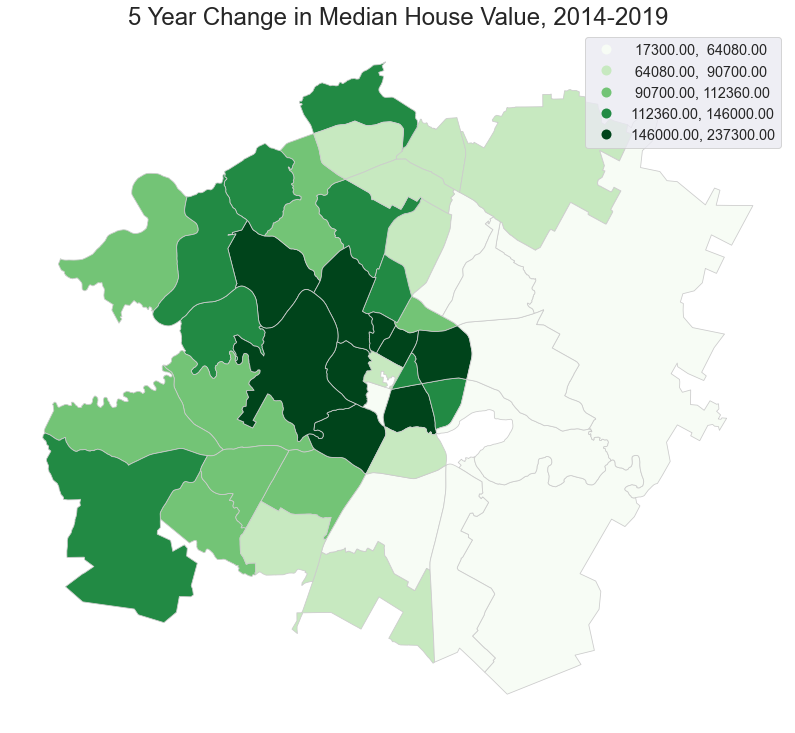

In [15]:
fig,ax = plt.subplots(1, figsize=(14,14))
ax.axis("off")
ax.set_title("5 Year Change in Median House Value, 2014-2019", fontsize = 24)
df_geo[df_geo['year'] == 2014].plot(column = '5Y CHG: Hsg: Median House Val', 
                  linewidth=0.8, ax=ax, edgecolor="0.8", 
                  scheme = 'quantiles',legend=True,cmap='Greens',legend_kwds=dict(loc='upper right',fontsize='large',
                  frameon=True))

plt.show()

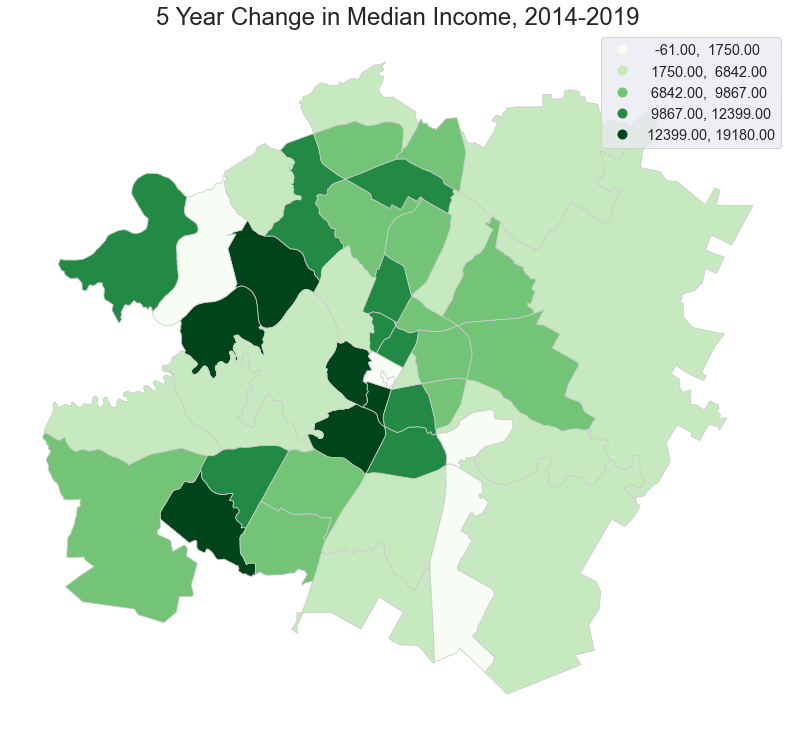

In [16]:
fig,ax = plt.subplots(1, figsize=(14,14))
ax.axis("off")
ax.set_title("5 Year Change in Median Income, 2014-2019", fontsize = 24)
df_geo[df_geo['year'] == 2014].plot(column = '5Y CHG: Inc: Median Income Past 12m', 
                  linewidth=0.8, ax=ax, edgecolor="0.8", 
                  scheme = 'naturalbreaks',legend=True,cmap='Greens',legend_kwds=dict(loc='upper right',fontsize='large',
                  frameon=True))

plt.show()

In [17]:
# df_geo['Gentrified 1Y Median'] = np.where(df['Gentrified 1Y Median']==True, 'Gentrified', 'Not Gentrified')
zip_gentrified = df_geo.groupby('zipcode')['Gentrified 1Y Median'].sum().reset_index()

In [18]:
df_geo_gentrified = gpd.GeoDataFrame(pd.merge(zip_gentrified, geo_zip, on = ('zipcode'), how = 'outer'))

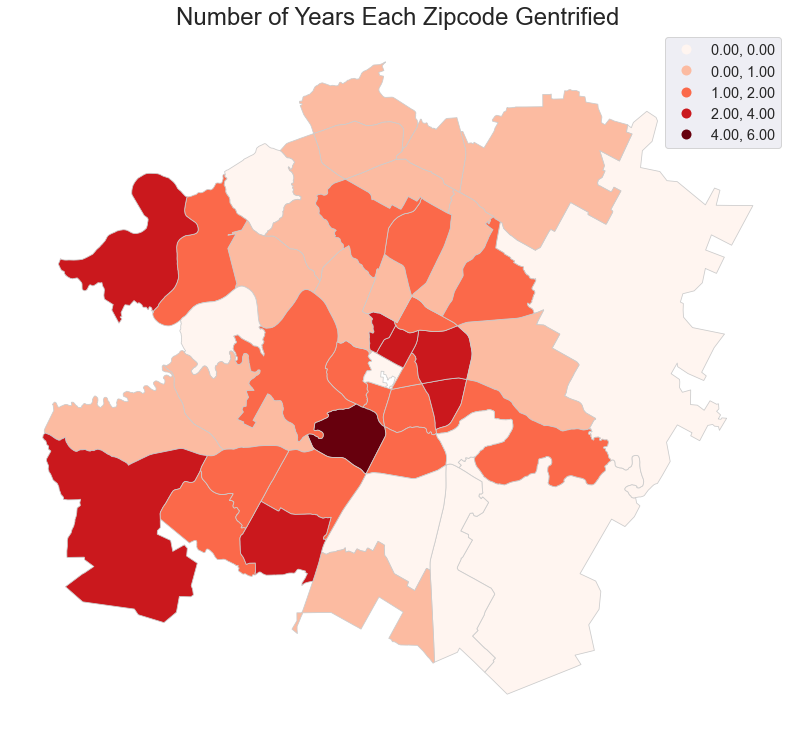

In [19]:
fig,ax = plt.subplots(1, figsize=(14,14))
ax.axis("off")
ax.set_title("Number of Years Each Zipcode Gentrified", fontsize = 24)
df_geo_gentrified.plot(column = 'Gentrified 1Y Median', 
                  linewidth=0.8, ax=ax, edgecolor="0.8",legend=True, cmap='Reds',scheme='natural_breaks',
                  legend_kwds=dict(loc='upper right',fontsize='large',
                  frameon=True))

plt.show()

## Demographic Map

In [20]:
# Creating column with common race
df_geo['most_common_race'] = df_geo.values[:,7:10].argmax(1)+1

def label_race(row):
  if row['most_common_race'] == 1:
    return "White"
  elif row['most_common_race'] == 2:
    return "Black"
  elif row['most_common_race'] == 3:
    return "Latino"
  else:
    return "Other"

In [21]:
df_geo['race_label'] = df_geo.apply(lambda row: label_race(row), axis=1)

In [22]:
df_geo.head()

year  1 year  5 years zipcode  Dem: Median Age  Dem: % <18  Dem: Pop  \
0  2011    2012     2016   78730             37.2    0.256491      8242   
1  2012    2013     2017   78730             38.2    0.256617      8312   
2  2013    2014     2018   78730             37.8    0.253477      8916   
3  2014    2015     2019   78730             36.2    0.238273      8591   
4  2015    2016     2020   78730             38.7    0.232894      8871   

   Div: % NH White  Div: % NH Black  Div: % Hispanic  ...  \
0         0.782820         0.025722         0.050352  ...   
1         0.817974         0.001925         0.054379  ...   
2         0.842306         0.003253         0.071108  ...   
3         0.835176         0.003492         0.093237  ...   
4         0.834968         0.000000         0.081614  ...   

   5Y CHG > Median Hsg: Median House Val  1Y CHG > 75th Hsg: Median House Val  \
0                                  False                                False   
1                                   True                                False   
2                                   True                                False   
3                                   True                                False   
4                                  False                                 True   

   5Y CHG > 75th Hsg: Median House Val  Gentrified 1Y Median  \
0                                False                 False   
1                                False                 False   
2                                 True                 False   
3                                 True                 False   
4                                False                 False   

   Gentrified 1Y 75th  Gentrified 5Y Median  Gentrified 5Y 75th  \
0               False                 False               False   
1               False                  True               False   
2               False                 False               False   
3               False                 False               False   
4               False                 False               False   

                                            geometry  most_common_race  \
0  MULTIPOLYGON (((-97.84397 30.39357, -97.84183 ...                 1   
1  MULTIPOLYGON (((-97.84397 30.39357, -97.84183 ...                 1   
2  MULTIPOLYGON (((-97.84397 30.39357, -97.84183 ...                 1   
3  MULTIPOLYGON (((-97.84397 30.39357, -97.84183 ...                 1   
4  MULTIPOLYGON (((-97.84397 30.39357, -97.84183 ...                 1   

   race_label  
0       White  
1       White  
2       White  
3       White  
4       White  

[5 rows x 94 columns]

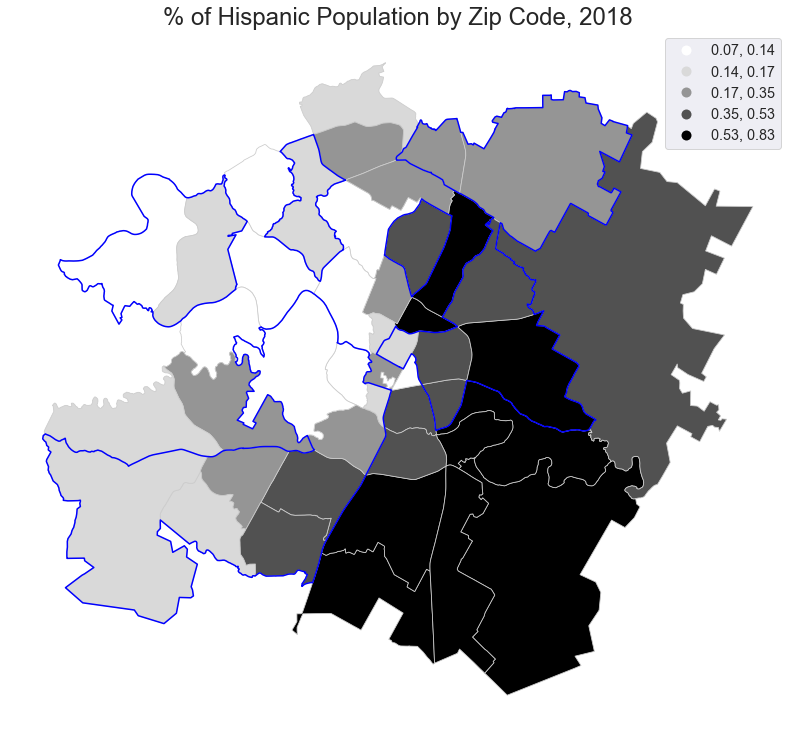

In [23]:
fig,ax = plt.subplots(1, figsize=(14,14))
ax.axis("off")
ax.set_title("% of Hispanic Population by Zip Code, 2018", fontsize = 24)
df_geo[df_geo['year'] == 2018].plot(column = 'Div: % Hispanic', 
                  linewidth=0.8, ax=ax, edgecolor="0.8",legend=True,
                  scheme='quantiles',cmap='Greys',legend_kwds=dict(loc='upper right',fontsize='large',
                  frameon=True))

df_geo.loc[(df_geo['year'] == 2018)&(df_geo['Gentrified 1Y Median'] == True)].dissolve('Gentrified 1Y Median').plot(legend=True, ax=ax, facecolor='none', edgecolor='blue', linewidth=1.5, alpha=1)

plt.show()

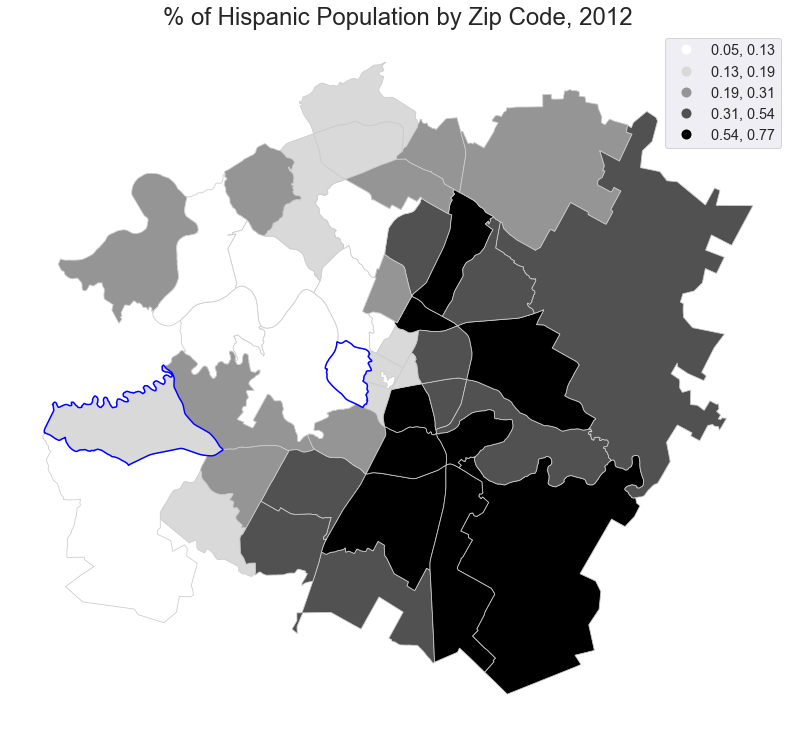

In [24]:
fig,ax = plt.subplots(1, figsize=(14,14))
ax.axis("off")
ax.set_title("% of Hispanic Population by Zip Code, 2012", fontsize = 24)
df_geo[df_geo['year'] == 2012].plot(column = 'Div: % Hispanic', 
                  linewidth=0.8, ax=ax, edgecolor="0.8",legend=True,
                  scheme='quantiles',cmap='Greys',legend_kwds=dict(loc='upper right',fontsize='large',
                  frameon=True))

df_geo.loc[(df_geo['year'] == 2012)&(df_geo['Gentrified 1Y Median'] == True)].dissolve('Gentrified 1Y Median').plot(legend=True, ax=ax, facecolor='none', edgecolor='blue', linewidth=1.5, alpha=1)

plt.show()